# 07 - Kaggle - bike share system - Random Forest


For problem formulation refer to **"01 - Kaggle - bike share system - problem formulation.ipynb"**.
In section **"02 - Kaggle - bike share system - Data preprocessing.ipynb"** we transformed the raw data and extracted time, date, and dummy matrices. The results are stored in two formats:
 * In `train_prep_orig.csv` and `test_prep_orig.csv` the categorical data are in the original form.
 * In `train_prep_dum.csv` and `test_prep_dum.csv` the categorical data are converted to dummy matrices. 

In section **03 - Kaggle - bike share system - data visualization.ipynb** we ploted the average of customers at different time periods over 2011 and 2012 and discused the pattern of customer behavior. We concluded by a decision to consider these average values as new features of the problem so that the machine learning model will be able to use them as the basis values and the other features apply the necessary correction to make use closer to the actual values. In **04 - Kaggle - bike share system - Adding customer average to the features.ipynb** we added the average customers as new featres to the data sets. We finally, update the data sets as:
 * In `train_prep_orig_avg.csv` and `test_prep_orig_avg.csv` the categorical data are in the original form.
 * In `train_prep_dum_avg.csv` and `test_prep_dum_avg.csv` the categorical data are converted to dummy matrices. 
 
 
In section **5 - Kaggle - bike share system - data analysis.ipynb** we visulaized and analyzed the data. We saw that instead of using average of customers as features, it is better if we use the target to be the deviation of customer from the average value.  

In section **06 - Kaggle - bike share system - Ordinary Linear Regression** we applied an ordinary linear regression. Fitting to deviation data has less `rmsle` than the actual data. Since the system is nonlinear, the linear models behave not so good, and we did not bother getting into the details of model improvement.

In this section, we use random forest regressors an a nonlinear model.


We use the data in `train_prep_orig_avg.csv`, which includes:
<center> temp|  atemp | humidity | windspeed | year | season | month | weekday | hour | workingday | holiday | weather | avg_casual | avg_registered | avg_tot | casual | registered | count
 </center>

- **temp**: temperature in Celsius. 

- **atemp**: "feels like" temperature in Celsius.

- **humidity**: relative humidity

- **windspeed**: wind speed

- **year**: 2011 or 2012

- **season**: Kaggle's [website](https://www.kaggle.com/c/bike-sharing-demand/data) says "`1 = spring, 2 = summer, 3 = fall, 4 = winter`", but the season indecies in the dataset correspond to 
    - 1 = Winter (January-March)
    - 2 = Spring (April-June)
    - 3 = Summer (July-September)
    - 4 = Fall (October-December)
    
- **month**: The month as January=1, December=12  

- **weekday**: The day of the week with Monday=0, Sunday=6

- **hour**: The hours of the datetime 0 - 23

- **workingday**: whether the day is neither a weekend nor holiday
     - 0 = day is weekend or holiday
     - 1 = otherwise 

- **holiday**: whether the day is considered a holiday 
    - 0 = non-holiday
    - 1 = holiday

- **weather**: encoded to make explicit various extreme weather events
    - 1 = Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2 = Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3 = Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds)
    - 4 = Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

- **casual**: number of non-registered user rentals initiated

- **registered**: number of registered user rentals initiated

- **tot**: number of total rentals (casual + registered)

- **avg_casual**: the average number of casual customers per weekday per month per year in a time period
- **avg_registered**:   the average number of registered customers per weekday per month per year in a time period
- **avg_tot**:  the average number of total customers per weekday per month per year in a time period





### Basic settings and importing the libraries

In [1]:
# Resets the namespace by removing all names defined by the user without asking for confirmation
%reset -f


# Panas is used for DataFrame
import pandas as pd

# NumPy is used for manipulating arrays
import numpy as np

# MatPlotLib is used for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# the output of plotting commands is displayed inline directly below the code cell that produced it.
%matplotlib inline

# Seaborn is used for statistical plotting
import seaborn as sns

# Used for display dataframes as html tables
from IPython.display import display

/Users/NanoResearch/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


The Root Mean Squared Logarithmic Error (RMSLE) is calculated as

$$\epsilon = \sqrt{{1\over n} \sum_{i=1}^n \left[ \log(p_i+1) - \log(a_i+1)\right]^2}$$

*Where:*

- $n_i$ is the number of hours in the test set
- $p_i$ is your predicted count
- $a_i$ is the actual count
- $\log(x)$ is the natural logarithm


First we define a `Score function` and them make a scorer from a performance metric or loss function for use in [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html). For this purpose we use [sklearn.metrics.make_scorer](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html)

In [2]:
from sklearn.metrics import make_scorer

def rmsle (y, y_pred):
    return np.sqrt(((np.log1p(y_pred) - np.log1p(y))**2).mean())

rmsle_score = make_scorer(rmsle, greater_is_better=False)

### Importing the train data from `train_prep_orig.csv`

In [3]:
#Load train data
data_train = pd.read_csv('data/train_prep_orig_avg.csv')

print "The shape of the train dataset:", data_train.shape
display(data_train.head())


The shape of the train dataset: (10886, 18)


,temp,atemp,humidity,windspeed,year,season,month,weekday,hour,workingday,holiday,weather,avg_casual,avg_registered,avg_tot,casual,registered,tot
0,9.84,14.395,81.0,0.0,2011.0,1.0,1.0,5.0,0.0,0.0,0.0,1.0,3.0,21.166667,24.166667,3.0,13.0,16.0
1,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,1.0,0.0,0.0,1.0,3.0,21.166667,24.166667,8.0,32.0,40.0
2,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,2.0,0.0,0.0,1.0,1.0,7.500000,8.500000,5.0,27.0,32.0
3,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,3.0,0.0,0.0,1.0,1.0,7.500000,8.500000,3.0,10.0,13.0
4,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,4.0,0.0,0.0,1.0,1.0,7.500000,8.500000,0.0,1.0,1.0


## Features and targets

In [4]:
cat_var = ['year','season', 'month', 'weekday', 'hour', 'workingday', 'holiday', 'weather']
num_var = ['temp', 'atemp', 'humidity', 'windspeed']
avg_var = ['avg_casual','avg_registered','avg_tot']
dev_var = ['dev_casual','dev_registered','dev_tot']
target_var = ['casual', 'registered', 'tot']


## Deviations of customers from average

In [5]:
data_train['dev_casual'] = data_train['casual'] - data_train['avg_casual'] 
data_train['dev_registered'] = data_train['registered'] - data_train['avg_registered'] 
data_train['dev_tot'] = data_train['tot'] - data_train['avg_tot'] 

data_train.head()

,temp,atemp,humidity,windspeed,year,season,month,weekday,hour,workingday,...,weather,avg_casual,avg_registered,avg_tot,casual,registered,tot,dev_casual,dev_registered,dev_tot
0,9.84,14.395,81.0,0.0,2011.0,1.0,1.0,5.0,0.0,0.0,...,1.0,3.0,21.166667,24.166667,3.0,13.0,16.0,0.0,-8.166667,-8.166667
1,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,1.0,0.0,...,1.0,3.0,21.166667,24.166667,8.0,32.0,40.0,5.0,10.833333,15.833333
2,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,2.0,0.0,...,1.0,1.0,7.500000,8.500000,5.0,27.0,32.0,4.0,19.500000,23.500000
3,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,3.0,0.0,...,1.0,1.0,7.500000,8.500000,3.0,10.0,13.0,2.0,2.500000,4.500000
4,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,4.0,0.0,...,1.0,1.0,7.500000,8.500000,0.0,1.0,1.0,-1.0,-6.500000,-7.500000


### Selecting feature ad target variables

In [6]:
X0 = data_train.loc[:,'temp':'avg_tot']
print "features with average values of target"
display(X0.head())

X = data_train.loc[:,'temp':'weather']
print "features"
display(X.head())

Y_avg = data_train.loc[:,'avg_casual':'avg_tot']
print "target (average)"
display(Y_avg.head())

Y_org = data_train.loc[:,'casual':'tot']
print "target"
display(Y_org.head())

Y_dev = data_train.loc[:,'dev_casual':'dev_tot']
print "target (deviation)"
display(Y_dev.head())

features with average values of target


,temp,atemp,humidity,windspeed,year,season,month,weekday,hour,workingday,holiday,weather,avg_casual,avg_registered,avg_tot
0,9.84,14.395,81.0,0.0,2011.0,1.0,1.0,5.0,0.0,0.0,0.0,1.0,3.0,21.166667,24.166667
1,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,1.0,0.0,0.0,1.0,3.0,21.166667,24.166667
2,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,2.0,0.0,0.0,1.0,1.0,7.500000,8.500000
3,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,3.0,0.0,0.0,1.0,1.0,7.500000,8.500000
4,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,4.0,0.0,0.0,1.0,1.0,7.500000,8.500000


features


,temp,atemp,humidity,windspeed,year,season,month,weekday,hour,workingday,holiday,weather
0,9.84,14.395,81.0,0.0,2011.0,1.0,1.0,5.0,0.0,0.0,0.0,1.0
1,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,1.0,0.0,0.0,1.0
2,9.02,13.635,80.0,0.0,2011.0,1.0,1.0,5.0,2.0,0.0,0.0,1.0
3,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,3.0,0.0,0.0,1.0
4,9.84,14.395,75.0,0.0,2011.0,1.0,1.0,5.0,4.0,0.0,0.0,1.0


target (average)


,avg_casual,avg_registered,avg_tot
0,3.0,21.166667,24.166667
1,3.0,21.166667,24.166667
2,1.0,7.500000,8.500000
3,1.0,7.500000,8.500000
4,1.0,7.500000,8.500000


target


,casual,registered,tot
0,3.0,13.0,16.0
1,8.0,32.0,40.0
2,5.0,27.0,32.0
3,3.0,10.0,13.0
4,0.0,1.0,1.0


target (deviation)


,dev_casual,dev_registered,dev_tot
0,0.0,-8.166667,-8.166667
1,5.0,10.833333,15.833333
2,4.0,19.500000,23.500000
3,2.0,2.500000,4.500000
4,-1.0,-6.500000,-7.500000


### Split to train and test samples

In [29]:
from sklearn.model_selection import train_test_split

X0_train, X0_test, X_train, X_test, Y_avg_train, Y_avg_test, Y_org_train, Y_org_test, Y_dev_train, Y_dev_test = train_test_split(
    X0,
    X, 
    Y_avg,
    Y_org, 
    Y_dev, 
    test_size = 0.30, 
    random_state = 42)

## MODEL: RANDOM FOREST REGRESSOR

Finding the baseline: here we simply go with the default setting to have a sense of possible outcomes

At frist, we only focus on total number of customers. We may extend the analysis later to casual and registered customers.

We set `random_state=10` for the sake of comparision, otherwise, in each run we get different resuts due to the random nature of the regressor.

To analyze the deviation of customer number from average, we use model's `.score` to calculate $R^2$ for deviation variables and regression score function `sklearn.metrics.r2_score(y_true, y_pred)` to analyze the goodness of fit after we include the average values.

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def fit_rf (X_train, Y_train, X_test, Y_test, n_trees = 10):
    rf = RandomForestRegressor(random_state=10, n_estimators= n_trees, criterion='mse')
    rf.fit(X_train,Y_train)    
    print ("Train R^2: %.3f " % rf.score(X_train,Y_train))
    print ("Test R^2: %.3f " % rf.score(X_test,Y_test))
    print ("Train rmsle: %.3f " % rmsle(Y_train, rf.predict(X_train)))
    print ("Test rmsle: %.3f " % rmsle(Y_test, rf.predict(X_test)))
     

def fit_rf_dev (X_train, Y_train, Y_0_train, X_test, Y_test, Y_0_test, n_trees = 10):
    rf = RandomForestRegressor(random_state=10, n_estimators= n_trees, criterion='mse')
    rf.fit(X_train,Y_train)    
    print ("dev Train R^2: %.3f " % rf.score(X_train,Y_train))
    print ("dev Test R^2: %.3f " % rf.score(X_test,Y_test))
    print ("Train R^2: %.3f " % r2_score(Y_train + Y_0_train, rf.predict(X_train) + Y_0_train))
    print ("Test R^2: %.3f " % r2_score(Y_test + Y_0_test, rf.predict(X_test) + Y_0_test)) 
    print ("Train rmsle: %.3f " % rmsle(Y_train + Y_0_train, rf.predict(X_train) + Y_0_train))
    print ("Test rmsle: %.3f " % rmsle(Y_test + Y_0_test, rf.predict(X_test) + Y_0_test))
    
for i in [10, 50, 100, 200, 500]:
    print "\n\n\nNo. trees:", i 
    print "\nFitting the original values (all features + average target value)"     
    fit_rf(X0_train, Y_org_train.tot, X0_test ,Y_org_test.tot,n_trees = i)
    print "\nFitting the deviation values (all features+ average target value)" 
    fit_rf_dev(X_train = X0_train, 
               Y_train = Y_dev_train.dev_tot, 
               Y_0_train = Y_avg_train.avg_tot, 
               X_test = X0_test , 
               Y_test = Y_dev_test.dev_tot, 
               Y_0_test = Y_avg_test.avg_tot, 
               n_trees = i )    
    print "\nFitting the original values (all features)"     
    fit_rf(X_train, Y_org_train.tot, X_test ,Y_org_test.tot,n_trees = i)
    print "\nFitting the deviation values (all features)" 
    fit_rf_dev(X_train = X_train, 
               Y_train = Y_dev_train.dev_tot, 
               Y_0_train = Y_avg_train.avg_tot, 
               X_test = X_test ,
               Y_test = Y_dev_test.dev_tot, 
               Y_0_test = Y_avg_test.avg_tot,
               n_trees = i )




No. trees: 10

Fitting the original values (all features + average target value)
Train R^2: 0.989 
Test R^2: 0.939 
Train rmsle: 0.162 
Test rmsle: 0.337 

Fitting the deviation values (all features+ average target value)
dev Train R^2: 0.973 
dev Test R^2: 0.848 
Train R^2: 0.990 
Test R^2: 0.946 
Train rmsle: 0.157 
Test rmsle: 0.329 

Fitting the original values (all features)
Train R^2: 0.989 
Test R^2: 0.944 
Train rmsle: 0.169 
Test rmsle: 0.344 

Fitting the deviation values (all features)
dev Train R^2: 0.973 
dev Test R^2: 0.838 
Train R^2: 0.990 
Test R^2: 0.943 
Train rmsle: 0.187 
Test rmsle: 0.393 



No. trees: 50

Fitting the original values (all features + average target value)
Train R^2: 0.992 
Test R^2: 0.944 
Train rmsle: 0.147 
Test rmsle: 0.323 

Fitting the deviation values (all features+ average target value)
dev Train R^2: 0.980 
dev Test R^2: 0.856 
Train R^2: 0.992 
Test R^2: 0.949 
Train rmsle: 0.142 
Test rmsle: 0.344 

Fitting the original values (all fe

#### note:

So RF shows a much better performance than OLR since it can catch the nonlinrearities. The $R^2$ for train dataset is always more than that of test data set, which suggests we have overfitting. Contrary to linear regression, here `rmsle` of the original values behaves better than the deviation values. 

Here is another interesting issue: the $R^2$ behaves better (higher value) for features *without* including the average target values while on the contrary `rmsle` behaves better (lower value) for features including the average target values. This may be due to the fact that `rmsle` measures the order of magnitude difference while $R^2$ is based on the actual values. 


In section **5 - Kaggle - bike share system - data analysis.ipynb** we saw that that deviation vales have very low (zero) correlation with `year`, `season`, `month`, `hour`, and `weekday`. So, let's take these out of the data and so the analysis again:

In [40]:
display(X_train.head())

correlated_features = ['temp','atemp','humidity','windspeed','weather','workingday','holiday']
correlated_features_avg = ['temp','atemp','humidity','windspeed','weather','workingday','holiday','avg_casual','avg_registered','avg_tot']

for i in [10, 50, 100, 200, 500]:
    print "\n\n\nNo. trees:", i 
    print "\nFitting the deviation values (all features  + average target value)" 
    fit_rf_dev(X_train = X0_train, 
               Y_train = Y_dev_train.dev_tot, 
               Y_0_train = Y_avg_train.avg_tot, 
               X_test = X0_test ,
               Y_test = Y_dev_test.dev_tot, 
               Y_0_test = Y_avg_test.avg_tot,
               n_trees = i )
    print "\nFitting the deviation values (some features  + average target value)" 
    fit_rf_dev(X_train = X0_train[correlated_features_avg],
               Y_train = Y_dev_train.dev_tot, 
               Y_0_train = Y_avg_train.avg_tot, 
               X_test = X0_test [correlated_features_avg],
               Y_test = Y_dev_test.dev_tot, 
               Y_0_test = Y_avg_test.avg_tot,
               n_trees = i )
    print "\nFitting the deviation values (all features)" 
    fit_rf_dev(X_train = X_train, 
               Y_train = Y_dev_train.dev_tot, 
               Y_0_train = Y_avg_train.avg_tot, 
               X_test = X_test ,
               Y_test = Y_dev_test.dev_tot, 
               Y_0_test = Y_avg_test.avg_tot,
               n_trees = i )
    print "\nFitting the deviation values (some features)" 
    fit_rf_dev(X_train = X_train[correlated_features],
               Y_train = Y_dev_train.dev_tot, 
               Y_0_train = Y_avg_train.avg_tot, 
               X_test = X_test [correlated_features],
               Y_test = Y_dev_test.dev_tot, 
               Y_0_test = Y_avg_test.avg_tot,
               n_trees = i )


,temp,atemp,humidity,windspeed,year,season,month,weekday,hour,workingday,holiday,weather
613,9.02,9.090,32.0,39.0007,2011.0,1.0,2.0,1.0,17.0,1.0,0.0,1.0
4030,22.14,25.760,68.0,12.9980,2011.0,3.0,9.0,6.0,23.0,0.0,0.0,1.0
3582,26.24,28.790,83.0,0.0000,2011.0,3.0,8.0,4.0,4.0,1.0,0.0,1.0
10101,9.02,11.365,69.0,8.9981,2012.0,4.0,11.0,1.0,6.0,1.0,0.0,1.0
1430,13.12,14.395,81.0,30.0026,2011.0,2.0,4.0,1.0,11.0,1.0,0.0,3.0





No. trees: 10

Fitting the deviation values (all features  + average target value)
dev Train R^2: 0.973 
dev Test R^2: 0.848 
Train R^2: 0.990 
Test R^2: 0.946 
Train rmsle: 0.157 
Test rmsle: 0.329 

Fitting the deviation values (some features  + average target value)
dev Train R^2: 0.803 
dev Test R^2: -0.034 
Train R^2: 0.926 
Test R^2: 0.633 
Train rmsle: 0.342 
Test rmsle: 0.649 

Fitting the deviation values (all features)
dev Train R^2: 0.973 
dev Test R^2: 0.838 
Train R^2: 0.990 
Test R^2: 0.943 
Train rmsle: 0.187 
Test rmsle: 0.393 

Fitting the deviation values (some features)
dev Train R^2: 0.669 
dev Test R^2: -0.217 
Train R^2: 0.876 
Test R^2: 0.568 
Train rmsle: 0.595 
Test rmsle: 0.816 



No. trees: 50

Fitting the deviation values (all features  + average target value)
dev Train R^2: 0.980 
dev Test R^2: 0.856 
Train R^2: 0.992 
Test R^2: 0.949 
Train rmsle: 0.142 
Test rmsle: 0.344 

Fitting the deviation values (some features  + average target value)
dev Train 

### Note:
As we see, removing the features (`year`, `season`, `month`, `hour`, and `weekday`) with zero/negligible correlation values makes the predictions worse. This can be due to nonlinearity and seasonality effects. Also, still the actual values perform better than the deviation values.  


So, to summarize so far, we learned that the actual feature values combined with average target values give the best results for `rmsle` values for different number of trees in the ensemble. Next, we see go for a cross validation.  

# Cross validation

In [45]:
from sklearn.model_selection import KFold

def fit_rf_cv (X_train, Y_train, X_test, Y_test, n_trees = 10):
    rf = RandomForestRegressor(random_state=10, n_estimators= n_trees, criterion='mse')
    rf.fit(X_train,Y_train)    
    return rmsle(Y_train, rf.predict(X_train)), rmsle(Y_test, rf.predict(X_test))

kf = KFold(n_splits=10)



In [83]:
for i in [10, 50, 100, 200, 500, 1000, 2000]:
    print "\n\n\nNo. trees:", i 
    train_rmsle = np.array([])
    test_rmsle = np.array([])
    for train_index, test_index in kf.split(X0):
        #print train_index, test_index
        X0_train, X0_test = X0.iloc[train_index], X0.iloc[test_index]
        Y_train, Y_test = Y_org.iloc[train_index].tot, Y_org.iloc[test_index].tot
        rmsle1, rmsle2 = fit_rf_cv (X0_train, Y_train, X0_test, Y_test, n_trees = i)
        print (rmsle1, rmsle2)
        train_rmsle = np.append(train_rmsle, rmsle1)
        test_rmsle = np.append(test_rmsle, rmsle2)
    
    print ("Train rmsle: %.6f +- %.6f " % (train_rmsle.mean(), train_rmsle.std()/2))
    print ("Test rmsle: %.6f +- %.6f " % (test_rmsle.mean(), test_rmsle.std()/2))
    




No. trees: 10
(0.15129720872769167, 0.60370242004530805)
(0.15357703460243302, 0.42671664266091575)
(0.15939358847326851, 0.28569115037482534)
(0.15360682563024836, 0.36396379652860483)
(0.15364140424739239, 0.35514372218449985)
(0.15177452317683873, 0.43791296733820323)
(0.15461371354608539, 0.33378578535304848)
(0.1577674540027261, 0.28845768001123095)
(0.15963798569200222, 0.30549657695377175)
(0.15212594955555536, 0.31308412135832425)
Train rmsle: 0.154744 +- 0.001468 
Test rmsle: 0.371395 +- 0.046139 



No. trees: 50
(0.13961757753325774, 0.57736700082452774)
(0.13992248885686226, 0.42262247787380514)
(0.14633521650862719, 0.27573957813775274)
(0.14352482866417521, 0.35503811256306678)
(0.14373631906785247, 0.35115476937536488)
(0.14076664386473817, 0.43028363908663231)
(0.14080140901316257, 0.32162409637810813)
(0.14468855921497084, 0.27800155586512304)
(0.14470593678440261, 0.30030692650079882)
(0.14082866575873026, 0.30401993151567214)
Train rmsle: 0.142493 +- 0.001124 
Tes


`No. trees: 1000
(0.13569974312208047, 0.56813523828383361)
(0.1346899827500686, 0.41480549134273409)
(0.14092817892567486, 0.27312680927730615)
(0.13824982600091917, 0.35683226803219142)
(0.13976712279074394, 0.34554518964494307)
(0.1372719519840325, 0.42112082871005158)
(0.13754206201948699, 0.31835595852997445)
(0.14059017785381117, 0.27479555894608887)
(0.13973864623843324, 0.29246593263679005)
(0.13787776054906509, 0.29995741531071529)
Train rmsle: 0.138236 +- 0.000974 
Test rmsle: 0.356514 +- 0.043262 `



`No. trees: 2000
(0.13553891662342055, 0.56944985981369101)
(0.13460813571607064, 0.41490169909328806)
(0.14068635886921235, 0.27317005368560088)
(0.13802728450753177, 0.35628063261470999)
(0.13949750003268882, 0.34561501913681636)
(0.13702575007851983, 0.41978505419833889)
(0.13743346357848296, 0.31859803607374532)
(0.14034317738478563, 0.27468333420826213)
(0.13970879371715628, 0.2924774766771257)
(0.13772764093256473, 0.29983592080735572)
Train rmsle: 0.138060 +- 0.000958 
Test rmsle: 0.356480 +- 0.043378 `



### Note:
In all ensembles we observe overfitting. 


## out-of-bag (OOB) error 

So, next we calculate and plot the out-of-bag (OOB) error as we increase the number of trees. We follow: http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

Regressor:  RandomForestRegressor, max_features='sqrt'
number of trees:  10
number of trees:  20
number of trees:  30
number of trees:  40
number of trees:  50
number of trees:  60
number of trees:  70
number of trees:  80
number of trees:  90
number of trees:  100
number of trees:  150
number of trees:  200
number of trees:  250
number of trees:  300
number of trees:  350
number of trees:  400
number of trees:  450
number of trees:  500
number of trees:  600
number of trees:  700
number of trees:  800
number of trees:  900
number of trees:  1000
Regressor:  RandomForestRegressor, max_features=None
number of trees:  10
number of trees:  20
number of trees:  30
number of trees:  40
number of trees:  50
number of trees:  60
number of trees:  70
number of trees:  80
number of trees:  90
number of trees:  100
number of trees:  150
number of trees:  200
number of trees:  250
number of trees:  300
number of trees:  350
number of trees:  400
number of trees:  450
number of trees:  500
number 

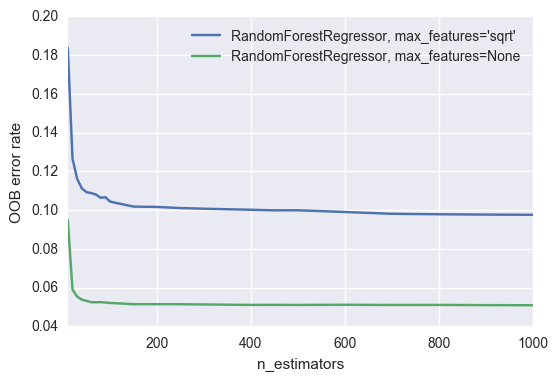

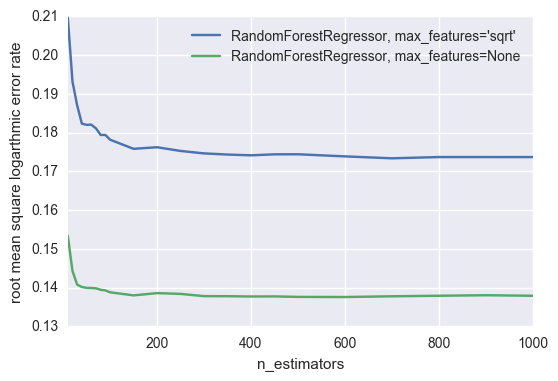

In [106]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.

ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(warm_start=True, 
                              oob_score=True,
                              max_features="sqrt",
                              random_state=10)),

# the number of features are 15 and log2(15) is almost equal to sqrt(15) 
# so they will give the same results and we only go with one of them.     
#    ("RandomForestRegressor, max_features='log2'",
#        RandomForestRegressor(warm_start=True, 
#                              oob_score=True,
#                              max_features='log2',
#                              random_state=10)),
    
    ("RandomForestRegressor, max_features=None",
        RandomForestRegressor(warm_start=True, 
                              oob_score=True,
                              max_features=None,
                              random_state=10))
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
from collections import OrderedDict
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
rmsle_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

trees_num = range(10, 100, 10) + range (100,500,50) + range (500, 1001, 100)

for label, clf in ensemble_clfs:
    print "Regressor: ", label
    for i in trees_num:
        print "number of trees: ", i
        clf.set_params(n_estimators=i)
        clf.fit(X0, Y_org.tot)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        
        # Record the rmsle for each `n_estimators=i` setting.
        rmsl_error = rmsle(Y_org.tot, clf.predict(X0))
        rmsle_rate[label].append((i, rmsl_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min(trees_num), max(trees_num))
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()
                           
                           
for label, clf_err in rmsle_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min(trees_num), max(trees_num))
plt.xlabel("n_estimators")
plt.ylabel("root mean square logarthmic error rate")
plt.legend(loc="upper right")
plt.show()

### Note: 
Both `rmsle` and OOB error behave better under `auto/None` than `sqrt`.  

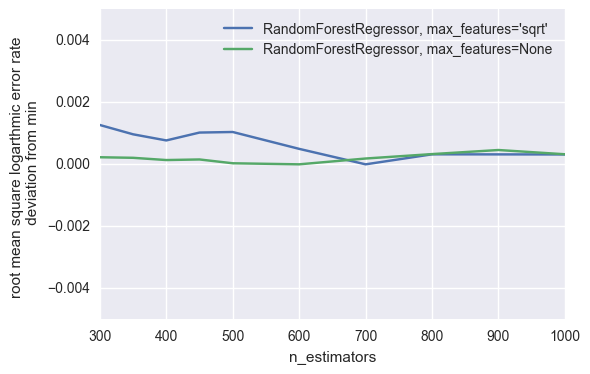

In [110]:
                           
for label, clf_err in rmsle_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys-min(ys), label=label)

plt.xlim(300, 1000)
plt.ylim(-0.005,0.005)
plt.xlabel("n_estimators")
plt.ylabel("root mean square logarthmic error rate \n deviation from min")
plt.legend(loc="upper right")
plt.show()

### Note: 
the best `rmsle` for `auto/None` appears around `n_estimators = 500` 

In [9]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

kf = KFold(n_splits=10)



def fit_rf_cv_dev (X_train, Y_train, Y_0_train, X_test, Y_test, Y_0_test, n_trees = 10):
    rf = RandomForestRegressor(random_state=10, n_estimators= n_trees, criterion='mse')
    rf.fit(X_train,Y_train)    
    return rmsle(Y_train + Y_0_train, rf.predict(X_train) + Y_0_train), rmsle(Y_test+ Y_0_test, rf.predict(X_test)+ Y_0_test) 

for i in [10, 50, 100, 200, 500, 1000, 2000]:
    print "\n\n\nNo. trees:", i 
    train_rmsle_dev = np.array([])
    test_rmsle_dev = np.array([])
    
    for train_index, test_index in kf.split(X0):
        #print train_index, test_index
        X0_train, X0_test = X0.iloc[train_index], X0.iloc[test_index]
        Y_train, Y_test = Y_dev.iloc[train_index].dev_tot, Y_dev.iloc[test_index].dev_tot
        Y_0_train, Y_0_test = Y_avg.iloc[train_index].avg_tot, Y_avg.iloc[test_index].avg_tot
        
        rmsle1_dev, rmsle2_dev = fit_rf_cv_dev (X_train = X0_train,  
                                                      Y_train = Y_train,
                                                      Y_0_train = Y_0_train,
                                                      X_test = X0_test,
                                                      Y_test = Y_test,
                                                      Y_0_test = Y_0_test,
                                                      n_trees = i)
        
        print (rmsle1_dev, rmsle2_dev)
        train_rmsle_dev = np.append(train_rmsle_dev, rmsle1_dev)
        test_rmsle_dev = np.append(test_rmsle_dev, rmsle2_dev)
    
    print ("Train rmsle: %.6f +- %.6f " % (train_rmsle_dev.mean(), train_rmsle_dev.std()/2))
    print ("Test rmsle: %.6f +- %.6f " % (test_rmsle_dev.mean(), test_rmsle_dev.std()/2))
    




No. trees: 10
(0.14990151879225455, 0.50015710734865004)
(0.14960644406271698, 0.38894287513551307)
(0.15625834652079762, 0.27125170159386408)
(0.15228922693964453, 0.34540201374723711)
(0.15371495011011535, 0.37338093708118991)
(0.15135087089948326, 0.40050352761187868)
(0.15106739119579318, 0.3332600046928953)
(0.15533828154009027, 0.28873337961874662)
(0.15618992225332171, 0.29375363921416608)
(0.15444321922123228, 0.29901428098401822)
Train rmsle: 0.153016 +- 0.001193 
Test rmsle: 0.349440 +- 0.032855 



No. trees: 50
(0.1389209650620484, 0.46451270840370951)
(0.13472637144900257, 0.36940959720583877)
(0.14203145556629349, 0.26774438128763262)
(0.13969253557037195, 0.34331382412657502)
(0.140156454258024, 0.30401183606036597)
(0.13966217299687747, 0.38106998519940866)
(0.13885603020825538, 0.32115463341478245)
(0.14248142706747174, 0.27695445487812498)
(0.14109354038377281, 0.29188409286535832)
(0.13948855103075988, 0.28472425564230874)
Train rmsle: 0.139711 +- 0.001018 
Test r